### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

$$\text{MSE}::-\frac{d}{da}L = 2 (y_i - a(x_i))$$

$$\text{Экспоненциальная}::-\frac{d}{da}L = y_i \exp(-a(x_i)y_i)$$

$$\text{Логистическая}::-\frac{d}{da}L = \frac{y_i \exp(-a(x_i)y_i)}{1 + \exp(-a(x_i)y_i)}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor

In [2]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='MSE', learning_rate=0.1, n_estimators=100,
                 colsample=1.0, subsample=1.0, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        if loss == 'MSE':
            self.__get_loss = self.__get_MSE
            self.__get_grad = self.__get_MSE_grad
        elif loss == 'exp':
            self.__get_loss = self.__get_exp
            self.__get_grad = self.__get_exp_grad
        else:
            self.__get_loss = self.__get_log
            self.__get_grad = self.__get_log_grad
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.attr_fract = colsample
        self.sample_fract = subsample
        self.noname_params = args
        self.withname_params = kwargs

    def __get_MSE(self, real, preds):
        return (real - preds) ** 2

    def __get_exp(self, real, preds):
        return np.exp(-preds * real)

    def __get_log(self, real, preds):
        return np.log(1 + np.exp(-preds * real))

    def __get_MSE_grad(self, real, preds):
        return 2 * (real - preds)

    def __get_exp_grad(self, real, preds):
        return real * np.exp(-preds * real)

    def __get_log_grad(self, real, preds):
        return real * np.exp(-preds * real) / (1 + np.exp(-preds * real))

    def __init_model(self, init_model):
        if init_model is None:
            self.booster = np.float64(np.ones(self.y.shape[0]) / self.y.shape[0])
            self.init_model = None
        else:
            self.init_model = init_model(*self.noname_params, **self.withname_params)
            self.init_model.fit(self.X, self.y)
            self.booster = np.float64(self.init_model.predict(self.X))
            
    def __choose_data(self):
        features_inds = np.random.randint(
            0, self.X.shape[1], size=int(self.X.shape[1] * self.attr_fract))
        self.features_inds.append(features_inds)
        objects_inds = np.random.randint(
            0, self.X.shape[0], size=int(self.X.shape[0] * self.sample_fract))
        X_algo = self.X[np.ix_(objects_inds, features_inds)]
        X_pred = self.X[:, features_inds]
        y_algo = self.y[objects_inds]
        prev_res = self.booster[objects_inds]
        return X_algo, X_pred, y_algo, prev_res

    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.X = X
        self.y = y

        self.__init_model(init_model)

        self.models = []
        self.features_inds = []
        for estimator in range(self.n_estimators):
            X_algo, X_pred, y_algo, prev_res = self.__choose_data()
            target = self.__get_grad(y_algo, prev_res)
            model = base_model(*self.noname_params, **self.withname_params)
            model.fit(X_algo, target)
            self.models.append(model)
            self.booster += self.learning_rate * \
                model.predict(X_pred)

    def predict(self, X):
        if self.init_model is None:
            preds = np.float64(np.ones(X.shape[0]) / X.shape[0])
        else:
            preds = np.float64(self.init_model.predict(X))
        for model, feat in zip(self.models, self.features_inds):
            preds += self.learning_rate * model.predict(X[:, feat])
        return np.around(preds)

In [3]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [7]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [8]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [9]:
opt_params = {}

In [10]:
def ValScore(n_splits=5, *args, **kwargs):
    clf = MyGradientBoostingClassifier(*args, **kwargs)
    kf = KFold(n_splits=n_splits)
    scores = []
    for train, test in kf.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scaler = StandardScaler().fit(X_train)
        scaler.transform(X_train)
        scaler.transform(X_test)
        clf.fit(X_train, y_train)
        scores.append(f1_score(y_pred=clf.predict(X_test),
                               y_true=y_test, average='macro'))
    return np.asarray(scores)

In [11]:
def FindParams(param_name, param_range, known_params=opt_params):
    mean_scores = []

    for param in param_range:
        kwargs = known_params
        kwargs.update({param_name: param})
        scores = ValScore(**kwargs)
        mean_scores.append(scores.mean())

    opt_param = param_range[np.argmax(mean_scores)]

    plt.figure(figsize=(10, 6))
    plt.xlabel(param_name)
    plt.ylabel('score')
    plt.title(f'Зависимость f1-score от параметра {param_name}\n'
              f'Оптимальное значение параметра {param_name}: {opt_param}')
    plt.plot(param_range, mean_scores)

    return opt_param

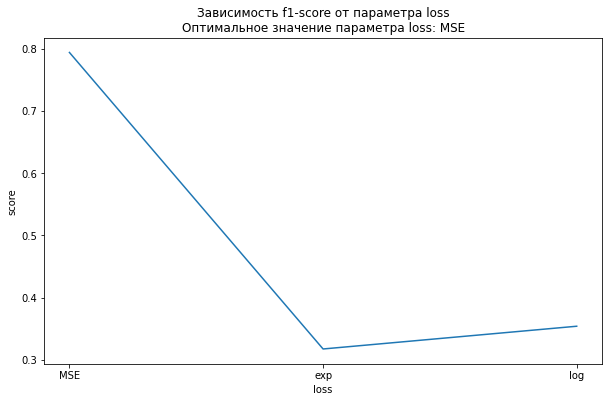

In [12]:
losses = ['MSE', 'exp', 'log']
opt_param = FindParams('loss', losses, opt_params)
opt_params.update({'loss': opt_param})

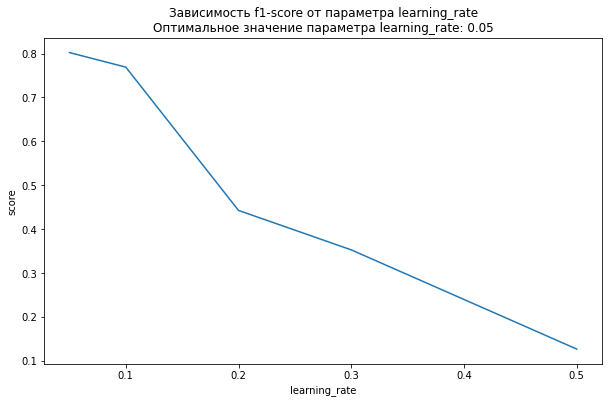

In [13]:
rates = [0.05, 0.1, 0.2, 0.3, 0.5]
opt_param = FindParams('learning_rate', rates, opt_params)
opt_params.update({'learning_rate': opt_param})

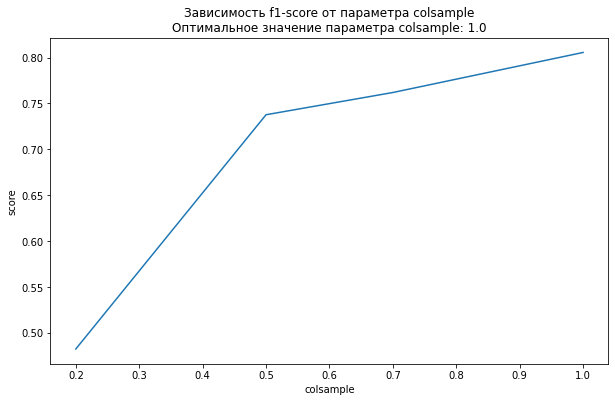

In [14]:
colsamples = [1.0, 0.7, 0.5, 0.2]
opt_param = FindParams('colsample', colsamples, opt_params)
opt_params.update({'colsample': opt_param})

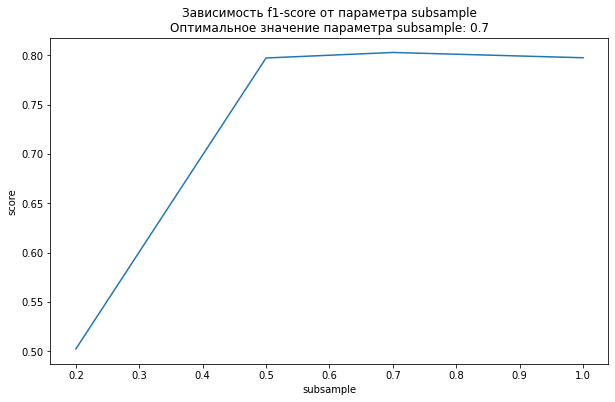

In [15]:
subsamples = [1.0, 0.7, 0.5, 0.2]
opt_param = FindParams('subsample', colsamples, opt_params)
opt_params.update({'subsample': opt_param})

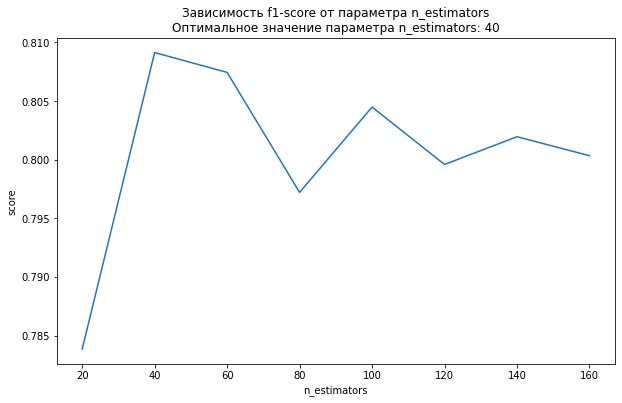

In [16]:
estimators = np.arange(20, 161, 20)
opt_param = FindParams('n_estimators', estimators, opt_params)
opt_params.update({'n_estimators': opt_param})

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [17]:
model = MyGradientBoostingClassifier(**opt_params)
model.fit(X_train, y_train, base_model=RandomForestRegressor)
accuracy_score(y_test, model.predict(X_test))

1.0

In [18]:
from multiprocessing.dummy import Pool
from tqdm.notebook import tqdm

In [19]:
def process_random_boost(i):
    model = MyGradientBoostingClassifier(**opt_params)
    samples_inds = np.random.randint(0, X_train.shape[0], size=int(X_train.shape[0] / N))
    X_boost = X_train[samples_inds, :]
    y_boost = y_train[samples_inds]
    model.fit(X_boost, y_boost)
    preds = model.predict(X_test)
    with lock:
        boots_res.append(preds)
        pbar.update(1)

In [20]:
N = 70
with Pool(10) as pool, tqdm(N) as pbar:
    boots_res = []
    lock = pbar.get_lock()
    pool.map(process_random_boost, range(N))
pool.join()
print(accuracy_score(y_test, np.sum(boots_res, axis=0) / N > 0.5))

0it [00:00, ?it/s]

0.3888888888888889


## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

In [22]:
model = MyGradientBoostingClassifier()
model.fit(X_train, y_train, init_model=SGDClassifier)
accuracy_score(y_test, model.predict(X_test))

0.5555555555555556

In [23]:
model = MyGradientBoostingClassifier()
model.fit(X_train, y_train, init_model=SVC)
accuracy_score(y_test, model.predict(X_test))

0.7222222222222222

In [24]:
model = MyGradientBoostingClassifier()
model.fit(X_train, y_train, init_model=RandomForestRegressor)
accuracy_score(y_test, model.predict(X_test))

1.0

In [25]:
model = MyGradientBoostingClassifier()
model.fit(X_train, y_train, init_model=RandomForestClassifier)
accuracy_score(y_test, model.predict(X_test))

1.0

Да, результат улучшился. Думаю потому, что лес выделил удачное направление с самого начала

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

